In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zh-wenyanwen-wikisource/cn_wenyan.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [4]:
df = pd.read_csv('/kaggle/input/zh-wenyanwen-wikisource/cn_wenyan.csv')
df.head()

,id,url,title,text
0,276713,https://zh.wikisource.org/wiki?curid=276713,跨鼇集 (四庫全書本)/卷11,跨鼇集 (四庫全書本)/卷11\n\n 欽定四庫全書\n 跨鼇集巻十一 宋 李...
1,276714,https://zh.wikisource.org/wiki?curid=276714,宋文鑑 (四庫全書本)/卷055,宋文鑑 (四庫全書本)/卷055\n\n 欽定四庫全書\n 宋 吕祖謙 編\n 徐州上...
2,276715,https://zh.wikisource.org/wiki?curid=276715,唐宋八大家文鈔 (四庫全書本)/卷128,唐宋八大家文鈔 (四庫全書本)/卷128\n\n 欽定四庫全書\n 唐宋八大家文鈔卷一百...
3,276716,https://zh.wikisource.org/wiki?curid=276716,跨鼇集 (四庫全書本)/卷12,跨鼇集 (四庫全書本)/卷12\n\n 欽定四庫全書\n 跨鼇集巻十二 宋 李...
4,276717,https://zh.wikisource.org/wiki?curid=276717,宋文鑑 (四庫全書本)/卷056,宋文鑑 (四庫全書本)/卷056\n\n 欽定四庫全書\n 宋 吕祖謙 編\n 上皇帝...


In [5]:
df.columns

Index(['id', 'url', 'title', 'text'], dtype='object')

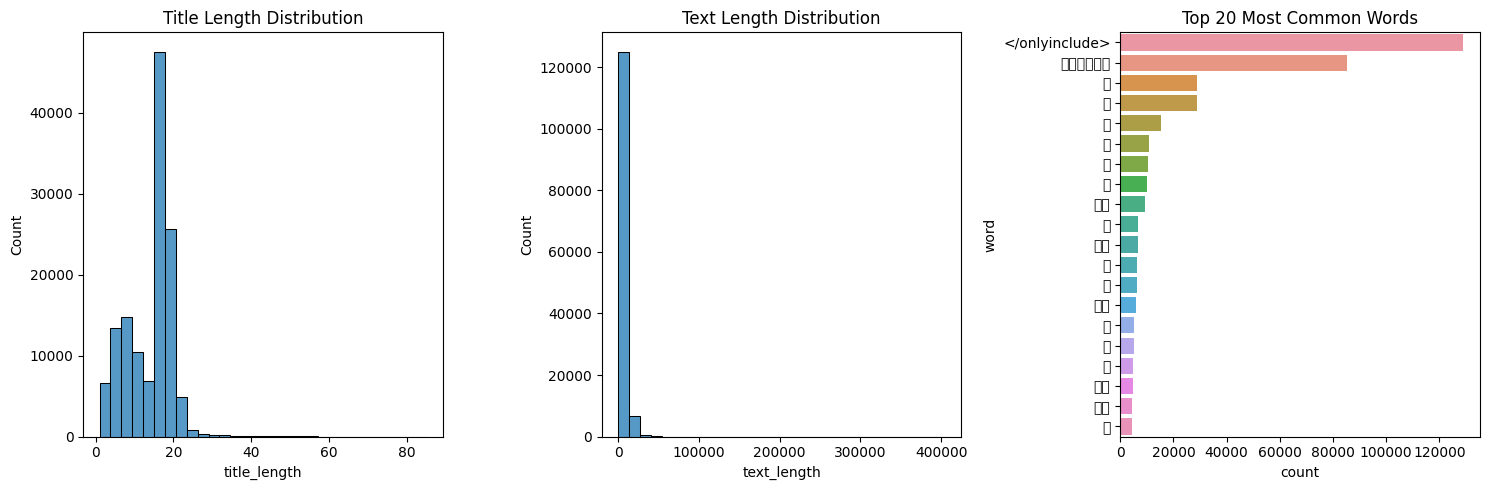

In [6]:
# Visualize the data
plt.figure(figsize=(15, 5))

# Plot title length distribution
df['title_length'] = df['title'].apply(len)
plt.subplot(1, 3, 1)
sns.histplot(df['title_length'], bins=30)
plt.title('Title Length Distribution')

# Plot text length distribution
df['text_length'] = df['text'].apply(len)
plt.subplot(1, 3, 2)
sns.histplot(df['text_length'], bins=30)
plt.title('Text Length Distribution')

# Plot top 20 most common words
from collections import Counter
all_words = ' '.join(df['text']).split()
word_counts = Counter(all_words)
top_words = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])
plt.subplot(1, 3, 3)
sns.barplot(y='word', x='count', data=top_words)
plt.title('Top 20 Most Common Words')

plt.tight_layout()
plt.show()

In [7]:
# Create categories based on text length
df['length_category'] = pd.qcut(df['text_length'], q=4, labels=['Very Short', 'Short', 'Long', 'Very Long'])

In [8]:
# Text vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['text'])
y = df['length_category']

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, predictions))

# Find best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]:.2f}")

Logistic Regression Accuracy: 0.65
              precision    recall  f1-score   support

        Long       0.56      0.71      0.62      6577
       Short       0.71      0.29      0.41      6565
   Very Long       0.69      0.65      0.67      6648
  Very Short       0.70      0.95      0.81      6672

    accuracy                           0.65     26462
   macro avg       0.66      0.65      0.63     26462
weighted avg       0.66      0.65      0.63     26462

Random Forest Accuracy: 0.66
              precision    recall  f1-score   support

        Long       0.56      0.73      0.63      6577
       Short       0.76      0.29      0.41      6565
   Very Long       0.71      0.64      0.67      6648
  Very Short       0.69      0.98      0.81      6672

    accuracy                           0.66     26462
   macro avg       0.68      0.66      0.63     26462
weighted avg       0.68      0.66      0.63     26462


Best Model: Random Forest with accuracy 0.66


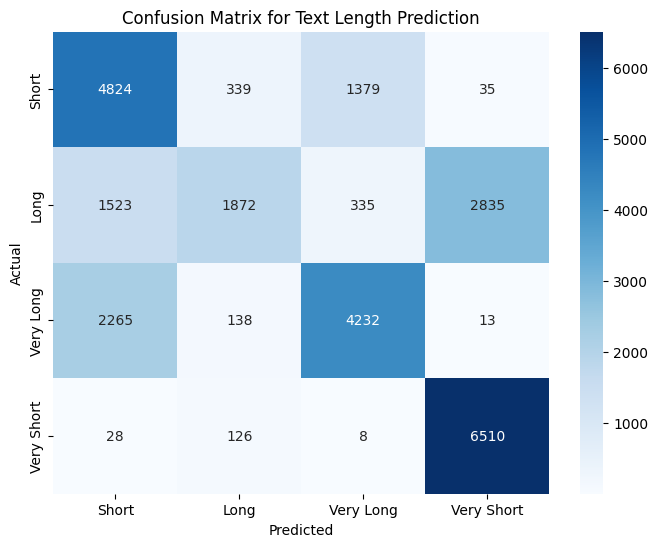

In [11]:
# Get predictions from best model
predictions = best_model.predict(X_test)

# Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['length_category'].unique(), 
            yticklabels=df['length_category'].unique())
plt.title('Confusion Matrix for Text Length Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

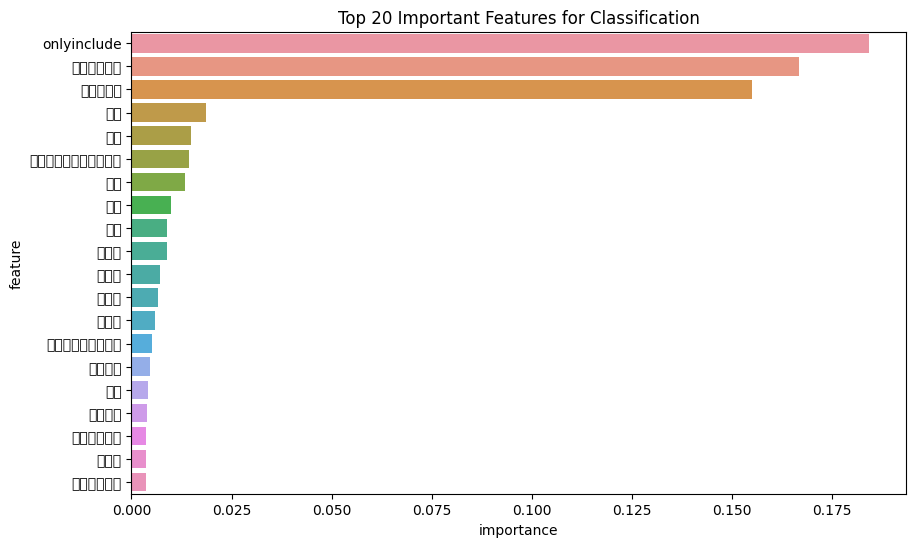

In [12]:
if best_model_name == "Random Forest":
    # Get feature importance
    importances = best_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()
    
    # Create DataFrame and sort
    feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False).head(20)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp)
    plt.title('Top 20 Important Features for Classification')
    plt.show()